In [1]:
from pyspark.sql import SQLContext, Row
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as sfn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
sc = SparkContext('local')
sqlCtx = SQLContext( sc )

In [3]:
df = sqlCtx.read.csv('data/titanic1.csv', header=True, inferSchema=True) 
df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


In [4]:
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = true)
 |-- Sex_index: double (nullable = true)
 |-- Embarked_index: double (nullable = true)
 |-- Initial_index: double (nullable = true)



In [10]:
# 0. age null 평균값을 채우시요..
# df.where('age is null').show() # age==null age=null (X)
m = df.rdd.map( lambda v:v['Age']).mean()
df=df.fillna({'age': m})

In [46]:
result.printSchema()

root
 |-- Pclass: integer (nullable = true)
 |-- aaa: double (nullable = true)



In [52]:
df["Pclass"]

Column<b'Pclass'>

In [55]:
df['aaa']

AnalysisException: 'Cannot resolve column name "aaa" among (Survived, Pclass, Age, SibSp, Parch, Fare, Family_Size, Alone, Sex_index, Embarked_index, Initial_index, 나이분류);'

In [54]:
result.toPandas().columns

Index(['Pclass', 'aaa'], dtype='object')

In [64]:
# 1. 등급별(pclass) 평균 생존을 구하시요
result = df.groupBy('Pclass').avg('Survived')
result = result.withColumnRenamed('avg(Survived)','aaa')
result.withColumn( 'aaa',result['aaa']*100 ).show()

+------+------------------+
|Pclass|               aaa|
+------+------------------+
|     1| 62.96296296296296|
|     3|24.236252545824847|
|     2| 47.28260869565217|
+------+------------------+



In [21]:
# 2. 혼자탑승(alone)한 인원의 평균 생존을 구하시요(1:혼자탑승)
df.groupBy('Alone').avg('Survived').show()

+-----+-------------------+
|Alone|      avg(Survived)|
+-----+-------------------+
|    1|0.30353817504655495|
|    0| 0.5056497175141242|
+-----+-------------------+



In [ ]:
# 3. 나이분류 컬럼을 추가하시요 
# 1~15(미성년자), 15~25(청년), 25~35(중년), 
# 35~60(장년), 60~(노년)  으로 표시하시요.


In [28]:
def fn(v):
    if v>=60:
        return '노년'
    elif v>=35:
        return '장년'
    elif v>=25:
        return '중년'
    elif v>=15:
        return '청년'
    else:
        return '미성년자'
    
ff = sfn.udf( fn )
df= df.withColumn( '나이분류', ff( df['Age'] )  )
df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|나이분류|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|    청년|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|    장년|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|    중년|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|    장년|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|    장년|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|    중년|
|       0|     1|54.0|    0|    0|5

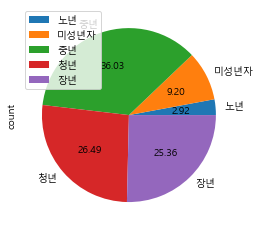

In [43]:
# 4. 나이분류를 파이차트로 표시하시요
p = df.groupBy('나이분류').count().toPandas()
p.plot(kind='pie', y='count', 
       labels= p['나이분류'], autopct='%.2f' )
plt.show()